In [89]:
%matplotlib inline

In [90]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# NumPy 2.0 compatibility
if not hasattr(np, 'float_'):
    np.float_ = np.float64
if not hasattr(np, 'complex_'):
    np.complex_ = np.complex128

os.environ['WANDB_DISABLED'] = 'true'

# Add project root
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from openstl.methods import SimVP

In [91]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

Using device: mps


In [92]:
model1_name = 'balanced_stage1_best.pth'
model2_name = 'balanced_stage2_best.pth'

log1_file = 'training_log_balanced_stage1.txt'
log2_file = 'training_log_balanced_stage2.txt'


In [93]:
def load_stage2_model():
    model_path = "models/"+model2_name
    
    model = SimVP(
        in_shape=(8, 1, 64, 64),
        pre_seq_length=8,
        aft_seq_length=24,
        hid_S=64, hid_T=256, N_S=4, N_T=4,
        dataname='single_fixation', metrics=[]
    ).to(device)
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Stage-2 loaded: Epoch {checkpoint['epoch']}, Val Loss {checkpoint['val_loss']:.3f}")
    else:
        model.load_state_dict(checkpoint)
        print("Stage-2 loaded: weights only")
    
    model.eval()
    return model

model = load_stage2_model()

Stage-2 loaded: Epoch 0, Val Loss 257.484


In [94]:
def load_validation_data():
    data_path = "data/val_data.pt"
    data = torch.load(data_path, map_location='cpu')
    if isinstance(data, dict) and 'frames' in data:
        frames = data['frames'].squeeze(1)
    else:
        frames = data.squeeze(1)
    
    print(f"Validation data loaded: {frames.shape}")
    return frames

data = load_validation_data()

Validation data loaded: torch.Size([100, 32, 32, 32])


In [95]:
def extract_coordinates(heatmap):
    if heatmap.max() == 0:
        return None, None
    flat_idx = heatmap.argmax()
    h, w = heatmap.shape
    y, x = flat_idx // w, flat_idx % w
    return x.item(), y.item()

In [96]:
def predict_sample(sample_idx):
    # Prepare data: 8->24 frames
    input_seq = data[sample_idx:sample_idx+1, :8]
    target_seq = data[sample_idx:sample_idx+1, 8:32]
    
    # Make prediction
    with torch.no_grad():
        input_tensor = input_seq.unsqueeze(2).contiguous().to(device)
        pred_seq = model(input_tensor)
        pred_seq = torch.sigmoid(pred_seq.squeeze(2))
        pred_seq = pred_seq.cpu()
    
    return input_seq, pred_seq, target_seq

# Test with sample 0
input_seq, pred_seq, target_seq = predict_sample(0)
print(f"Input shape: {input_seq.shape}")
print(f"Prediction shape: {pred_seq.shape}")
print(f"Target shape: {target_seq.shape}")

Input shape: torch.Size([1, 8, 32, 32])
Prediction shape: torch.Size([1, 24, 32, 32])
Target shape: torch.Size([1, 24, 32, 32])


In [97]:
def calculate_metrics(pred_seq, target_seq):
    pred_coords = []
    true_coords = []
    
    for t in range(pred_seq.shape[1]):
        pred_x, pred_y = extract_coordinates(pred_seq[0, t].numpy())
        true_x, true_y = extract_coordinates(target_seq[0, t].numpy())
        
        pred_coords.append((pred_x, pred_y) if pred_x is not None else None)
        true_coords.append((true_x, true_y) if true_x is not None else None)
    
    # Calculate accuracies
    distances = []
    for pred, true in zip(pred_coords, true_coords):
        if pred is not None and true is not None:
            dist = np.sqrt((pred[0] - true[0])**2 + (pred[1] - true[1])**2)
            distances.append(dist)
    
    if distances:
        acc_2px = np.mean(np.array(distances) <= 2)
        acc_3px = np.mean(np.array(distances) <= 3)
        acc_5px = np.mean(np.array(distances) <= 5)
        avg_error = np.mean(distances)
    else:
        acc_2px = acc_3px = acc_5px = 0.0
        avg_error = float('inf')
    
    return {
        'accuracy_2px': acc_2px,
        'accuracy_3px': acc_3px,
        'accuracy_5px': acc_5px,
        'avg_error': avg_error,
        'pred_coords': pred_coords,
        'true_coords': true_coords
    }

# Calculate metrics for sample 0
metrics = calculate_metrics(pred_seq, target_seq)
print(f"Accuracy (2px): {metrics['accuracy_2px']:.3f}")
print(f"Accuracy (3px): {metrics['accuracy_3px']:.3f}")
print(f"Accuracy (5px): {metrics['accuracy_5px']:.3f}")
print(f"Average Error: {metrics['avg_error']:.2f}px")

Accuracy (2px): 0.042
Accuracy (3px): 0.042
Accuracy (5px): 0.083
Average Error: 19.29px


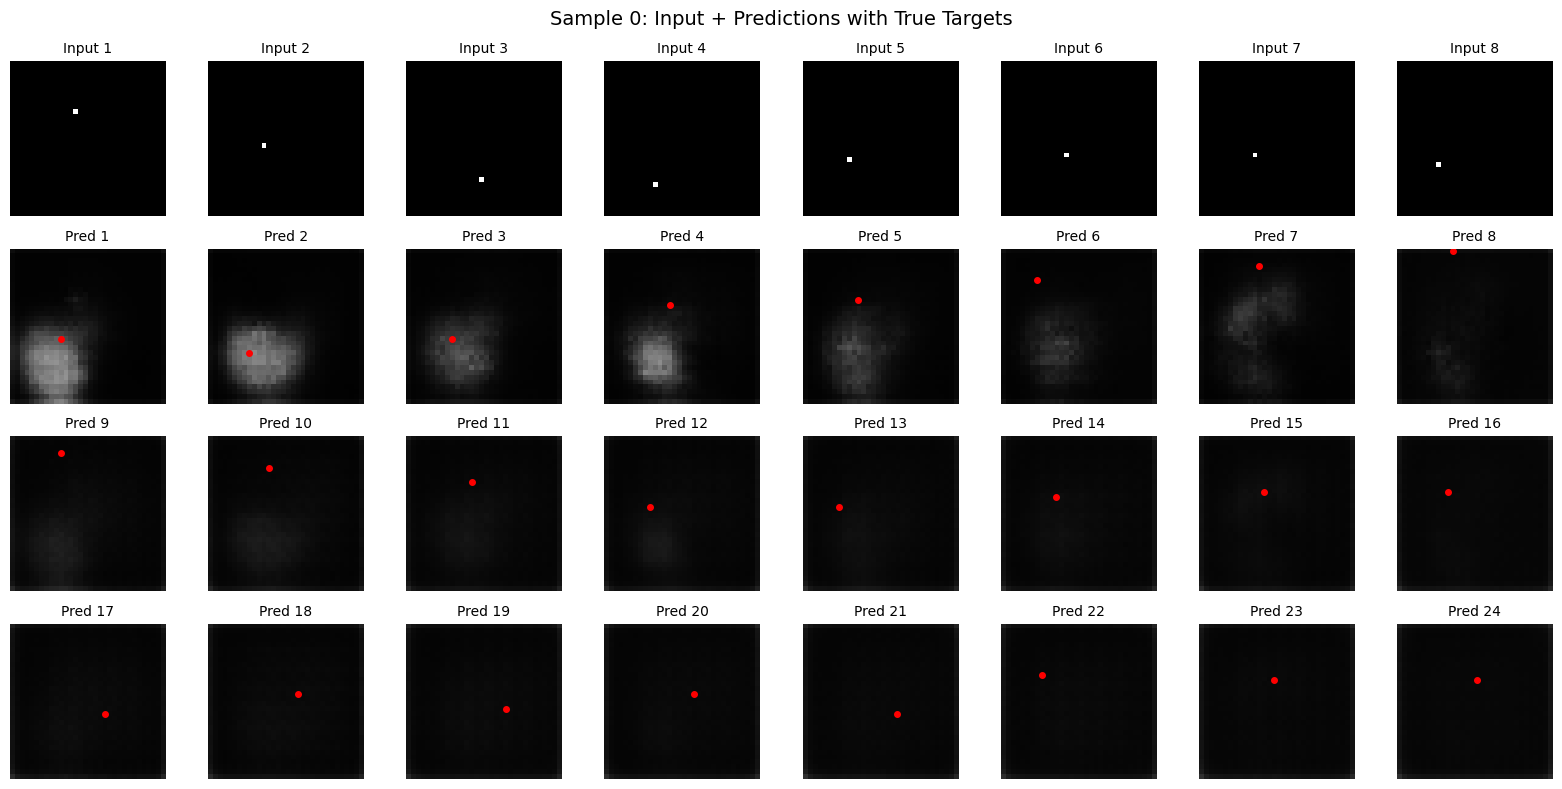

In [98]:
def visualize_sample(input_seq, pred_seq, target_seq, metrics, sample_idx=1):
    # Create 4x8 grid: 8 input frames + 24 prediction frames
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    
    fig.suptitle(f'Sample {sample_idx}: Input + Predictions with True Targets', fontsize=14)
    
    frame_idx = 0
    
    # Show input frames (first row)
    for t in range(8):
        axes[0, t].imshow(input_seq[0, t].numpy(), cmap='gray', vmin=0, vmax=1)
        axes[0, t].set_title(f'Input {t+1}', fontsize=10)
        axes[0, t].axis('off')
    
    # Show prediction frames (rows 2-4) with target overlay
    for t in range(24):
        row = 1 + t // 8
        col = t % 8
        
        # Show prediction
        pred_frame = pred_seq[0, t].numpy()
        axes[row, col].imshow(pred_frame, cmap='gray', vmin=0, vmax=1)
        
        # Overlay true target as red dot
        true_x, true_y = metrics['true_coords'][t]
        if true_x is not None:
            axes[row, col].plot(true_x, true_y, 'r.', markersize=8)
        
        axes[row, col].set_title(f'Pred {t+1}', fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample 0
visualize_sample(input_seq, pred_seq, target_seq, metrics, 0)


Processing sample 1/3...


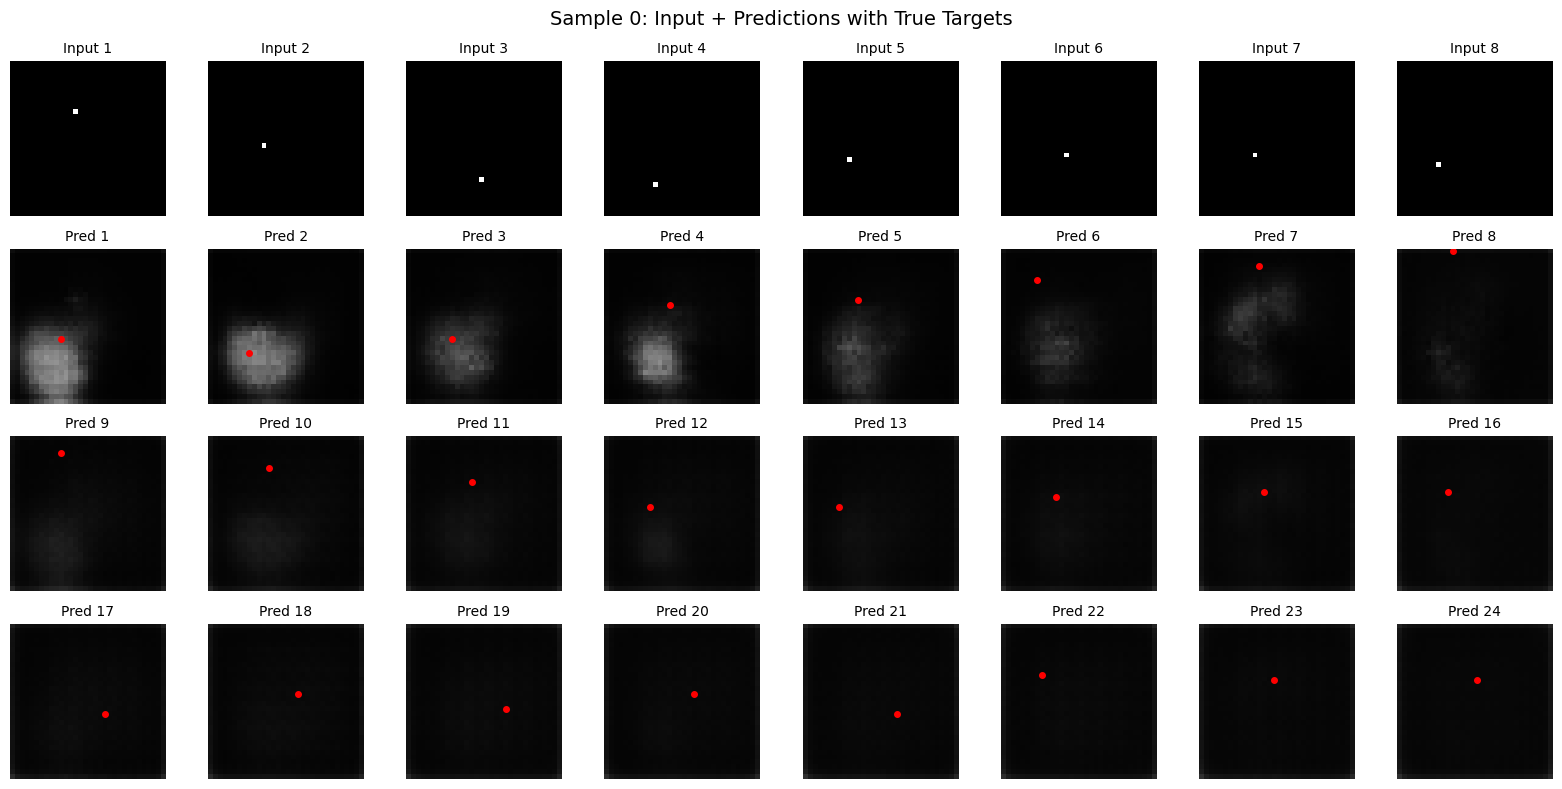

Sample 1 Metrics:
  Accuracy (2px): 0.042
  Accuracy (3px): 0.042
  Accuracy (5px): 0.083
  Average Error: 19.29px

Processing sample 2/3...


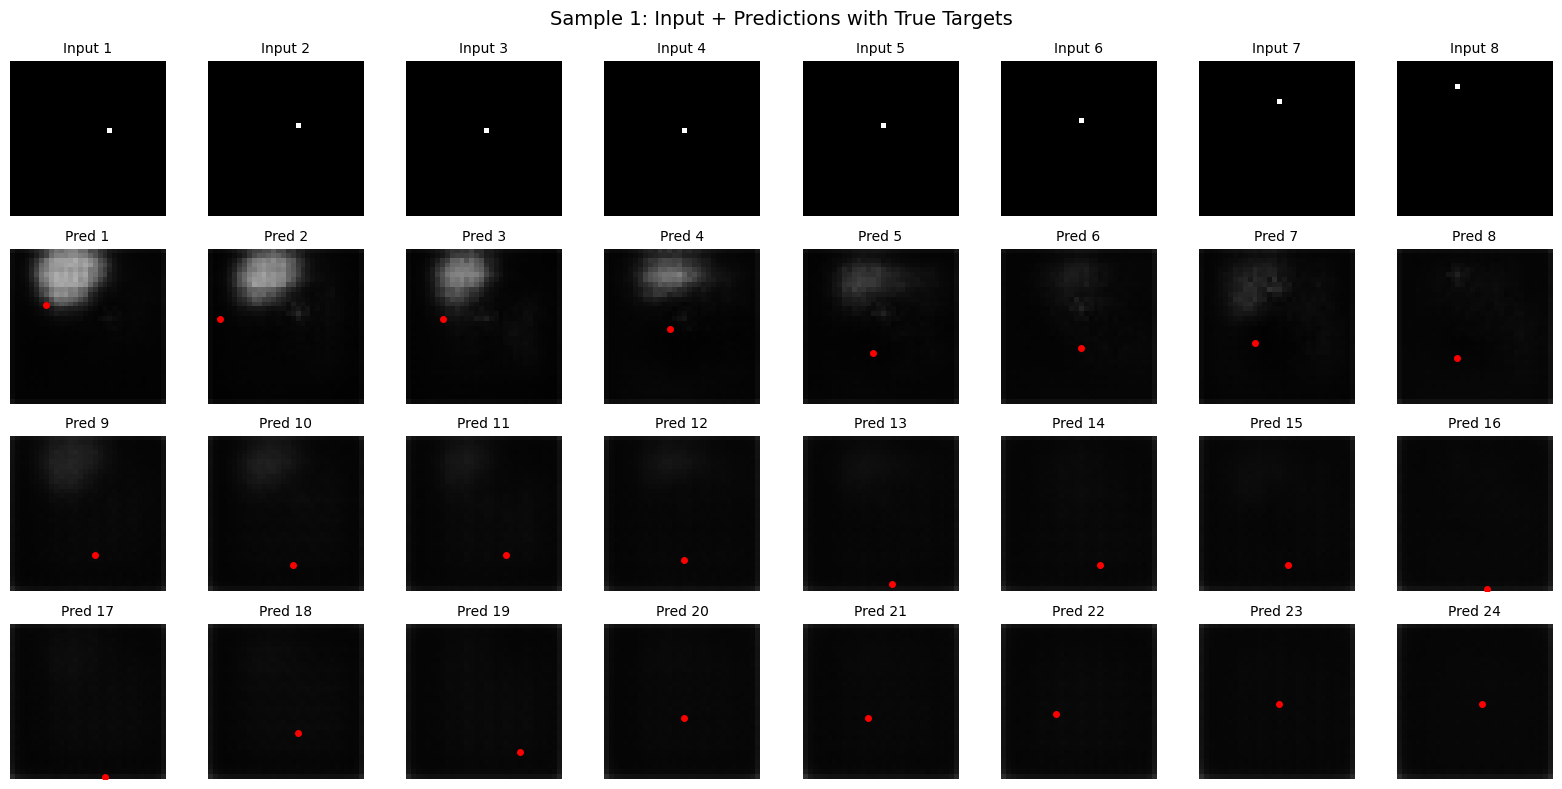

Sample 2 Metrics:
  Accuracy (2px): 0.000
  Accuracy (3px): 0.000
  Accuracy (5px): 0.000
  Average Error: 16.83px

Processing sample 3/3...


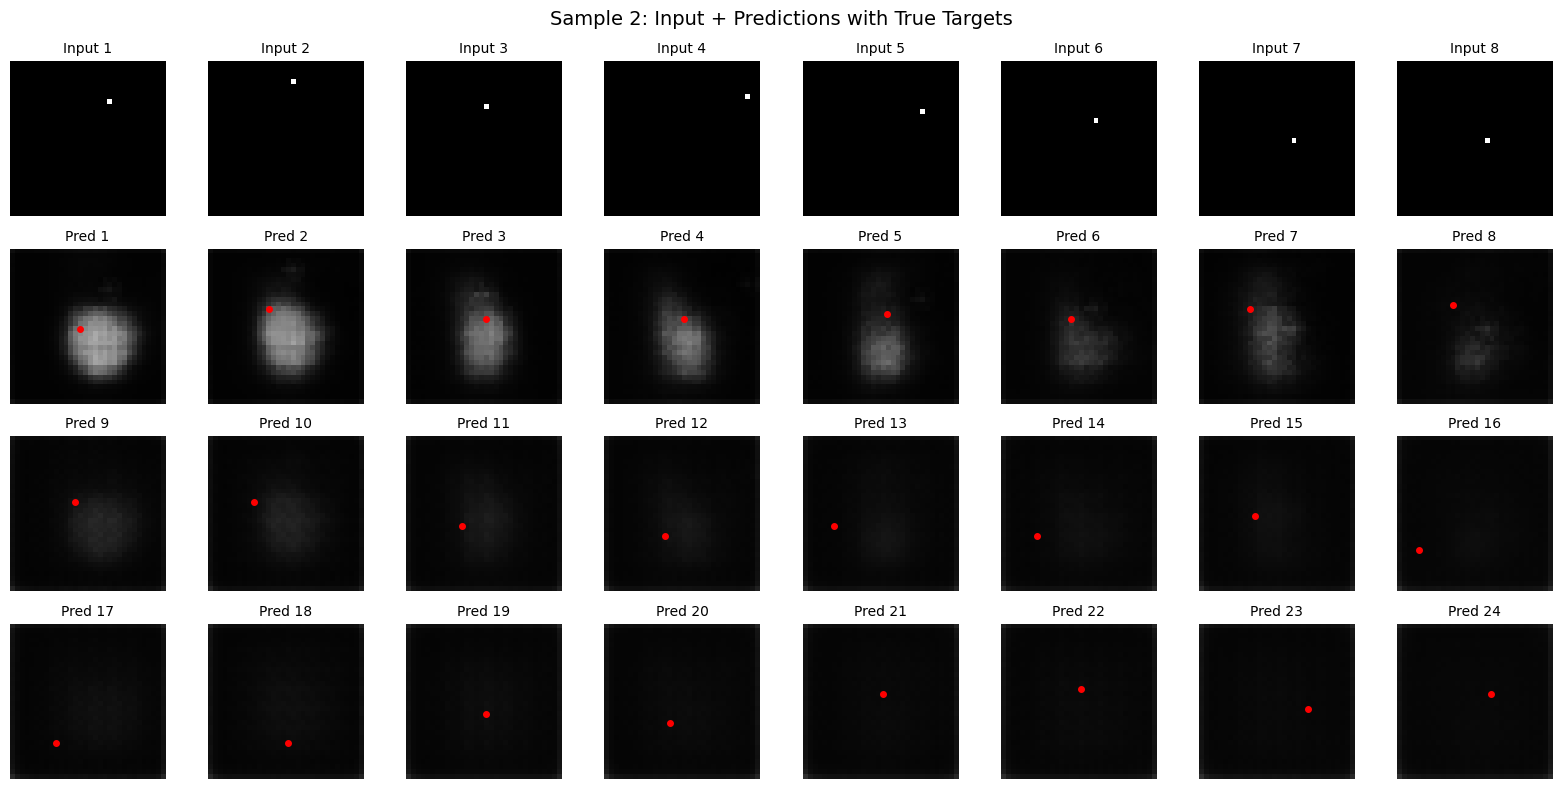

Sample 3 Metrics:
  Accuracy (2px): 0.000
  Accuracy (3px): 0.000
  Accuracy (5px): 0.083
  Average Error: 13.44px

=== Summary ===
Average Accuracy (2px): 0.014
Average Accuracy (3px): 0.014
Average Accuracy (5px): 0.056
Average Error: 16.52px


In [99]:
def evaluate_multiple_samples(num_samples=1):
    all_metrics = []
    
    for i in range(min(num_samples, len(data))):
        print(f"\nProcessing sample {i+1}/{num_samples}...")
        
        # Get prediction
        input_seq, pred_seq, target_seq = predict_sample(i)
        
        # Calculate metrics
        metrics = calculate_metrics(pred_seq, target_seq)
        all_metrics.append(metrics)
        
        # Visualize
        visualize_sample(input_seq, pred_seq, target_seq, metrics, i)
        
        # Print metrics
        print(f"Sample {i+1} Metrics:")
        print(f"  Accuracy (2px): {metrics['accuracy_2px']:.3f}")
        print(f"  Accuracy (3px): {metrics['accuracy_3px']:.3f}")
        print(f"  Accuracy (5px): {metrics['accuracy_5px']:.3f}")
        print(f"  Average Error: {metrics['avg_error']:.2f}px")
    
    # Summary statistics
    avg_acc_2px = np.mean([m['accuracy_2px'] for m in all_metrics])
    avg_acc_3px = np.mean([m['accuracy_3px'] for m in all_metrics])
    avg_acc_5px = np.mean([m['accuracy_5px'] for m in all_metrics])
    avg_error = np.mean([m['avg_error'] for m in all_metrics])
    
    print(f"\n=== Summary ===")
    print(f"Average Accuracy (2px): {avg_acc_2px:.3f}")
    print(f"Average Accuracy (3px): {avg_acc_3px:.3f}")
    print(f"Average Accuracy (5px): {avg_acc_5px:.3f}")
    print(f"Average Error: {avg_error:.2f}px")

# Evaluate 3 samples
evaluate_multiple_samples(3)

In [100]:
def load_stage1_model():
    model_path = "models/"+model1_name
    
    model = SimVP(
        in_shape=(8, 1, 64, 64),
        pre_seq_length=8,
        aft_seq_length=8,
        hid_S=64, hid_T=256, N_S=4, N_T=4,
        dataname='single_fixation', metrics=[]
    ).to(device)
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Stage-1 loaded: Epoch {checkpoint['epoch']}, Val Loss {checkpoint['val_loss']:.3f}")
    else:
        model.load_state_dict(checkpoint)
        print("Stage-1 loaded: weights only")
    
    model.eval()
    return model

def predict_stage1(sample_idx):
    # Prepare data: 8->8 frames
    input_seq = data[sample_idx:sample_idx+1, :8]
    target_seq = data[sample_idx:sample_idx+1, 8:16]
    
    stage1_model = load_stage1_model()
    
    with torch.no_grad():
        input_tensor = input_seq.unsqueeze(2).contiguous().to(device)
        pred_seq = stage1_model(input_tensor)
        pred_seq = torch.sigmoid(pred_seq.squeeze(2))
        pred_seq = pred_seq.cpu()
    
    return input_seq, pred_seq, target_seq

# Compare Stage-1 vs Stage-2 on same sample
print("=== Stage-1 (8->8) vs Stage-2 (8->24) Comparison ===")
sample_idx = 0

# Stage-1
input1, pred1, target1 = predict_stage1(sample_idx)
metrics1 = calculate_metrics(pred1, target1)
print(f"Stage-1: Error {metrics1['avg_error']:.2f}px, Acc5px {metrics1['accuracy_5px']:.3f}")

# Stage-2  
input2, pred2, target2 = predict_sample(sample_idx)
metrics2 = calculate_metrics(pred2, target2)
print(f"Stage-2: Error {metrics2['avg_error']:.2f}px, Acc5px {metrics2['accuracy_5px']:.3f}")

=== Stage-1 (8->8) vs Stage-2 (8->24) Comparison ===
Stage-1 loaded: Epoch 2, Val Loss 185.112
Stage-1: Error 15.30px, Acc5px 0.375
Stage-2: Error 19.29px, Acc5px 0.083


In [101]:
def plot_training_curves():
    log_file = 'training_log_fast.txt'
    if not os.path.exists(log_file):
        print(f"Log file not found: {log_file}")
        return
    
    # Read CSV log file
    try:
        df = pd.read_csv(log_file)
        epochs = df['Epoch'].values
        train_losses = df['Train_Loss'].values
        val_losses = df['Val_Loss'].values
    except Exception as e:
        print(f"Error reading log file: {e}")
        return
    
    if len(epochs) == 0:
        print("No training data found in log file")
        return
    
    plt.figure(figsize=(18, 6))
    
    # Left column: Training curves
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 2)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Curves (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Right column: Loss components
    plt.subplot(2, 3, 3)
    plt.plot(epochs, df['Train_Focal'], 'g-', label='Focal', linewidth=2)
    plt.plot(epochs, df['Train_Concentration'], 'c-', label='Concentration', linewidth=2)
    if 'Train_Coord' in df.columns:
        plt.plot(epochs, df['Train_Coord'], 'orange', label='Coord', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Components')
    plt.title('Loss Components')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Bottom row: Training time and component ratios
    plt.subplot(2, 3, 4)
    plt.plot(epochs, df['Time'], 'purple', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Training Time per Epoch')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 5)
    avg_train = np.mean(train_losses[-5:])  # Last 5 epochs
    avg_val = np.mean(val_losses[-5:])
    best_val = np.min(val_losses)
    plt.bar(['Final Train', 'Final Val', 'Best Val'], 
            [avg_train, avg_val, best_val])
    plt.title('Loss Summary')
    plt.ylabel('Loss Value')
    
    # Component ratios
    plt.subplot(2, 3, 6)
    if 'Train_Coord' in df.columns:
        total_components = df['Train_Focal'] + df['Train_Sparsity'] + df['Train_Concentration'] + df['Train_KL'] + df['Train_Coord']
        plt.plot(epochs, df['Train_Coord'] / total_components, label='Coord %', linewidth=2)
    else:
        total_components = df['Train_Focal'] + df['Train_Sparsity'] + df['Train_Concentration'] + df['Train_KL']
    
    plt.plot(epochs, df['Train_Focal'] / total_components, label='Focal %', linewidth=2)
    plt.plot(epochs, df['Train_Concentration'] / total_components, label='Concentration %', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Component Ratio')
    plt.title('Loss Component Ratios')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Training completed in {len(epochs)} epochs")
    print(f"Final train loss: {train_losses[-1]:.4f}")
    print(f"Final val loss: {val_losses[-1]:.4f}")
    print(f"Best val loss: {min(val_losses):.4f} at epoch {epochs[val_losses.argmin()]}")


=== Stage 1 Summary ===
Training completed in 23 epochs
Final train loss: 18.1200
Final val loss: 249.0033
Best val loss: 185.1125 at epoch 2

=== Stage 2 Summary ===
Training completed in 21 epochs
Final train loss: 84.4033
Final val loss: 335.4617
Best val loss: 257.4839 at epoch 0


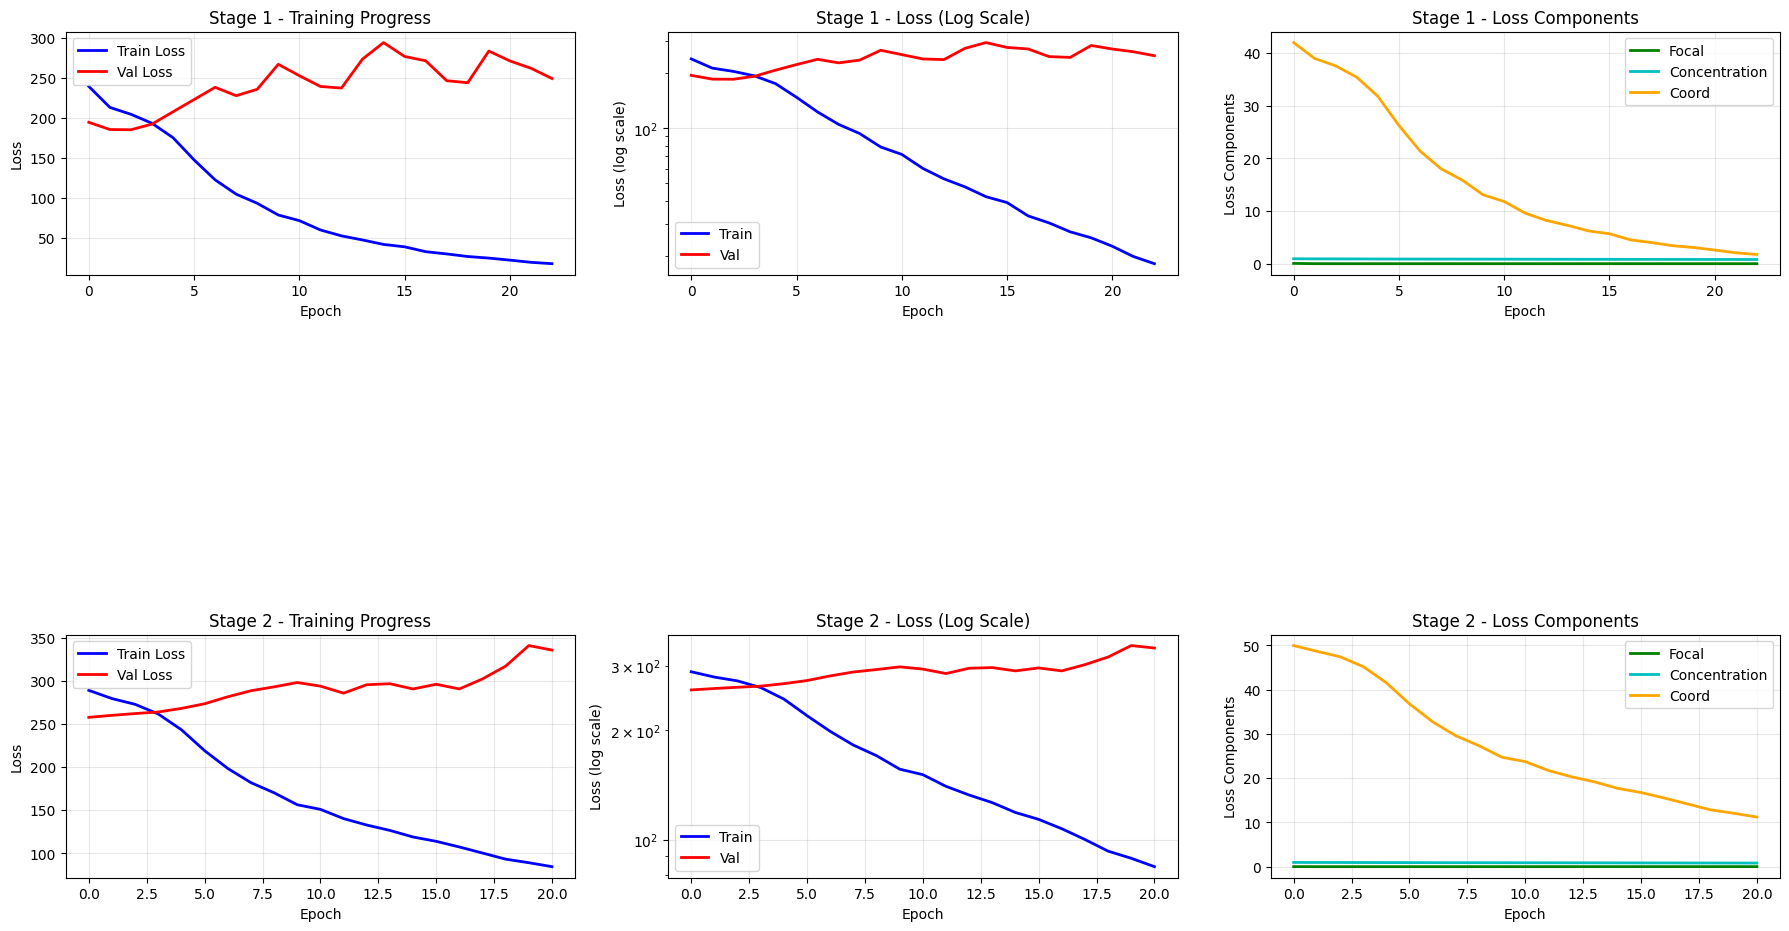

In [102]:
def plot_training_curves():
    log_files = [
        log1_file,
        log2_file
    ]
    
    plt.figure(figsize=(18, 12))
    
    for idx, log_file in enumerate(log_files):
        if not os.path.exists(log_file):
            print(f"Log file not found: {log_file}")
            continue
        
        # Read CSV log file
        try:
            df = pd.read_csv(log_file)
            epochs = df['Epoch'].values
            train_losses = df['Train_Loss'].values
            val_losses = df['Val_Loss'].values
        except Exception as e:
            print(f"Error reading log file {log_file}: {e}")
            continue
        
        if len(epochs) == 0:
            print(f"No training data found in {log_file}")
            continue
        
        # Create subplots for each stage (2 rows per stage)
        base_row = idx * 2
        
        # Training curves
        plt.subplot(4, 3, base_row * 3 + 1)
        plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
        plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Stage {idx+1} - Training Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(4, 3, base_row * 3 + 2)
        plt.semilogy(epochs, train_losses, 'b-', label='Train', linewidth=2)
        plt.semilogy(epochs, val_losses, 'r-', label='Val', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log scale)')
        plt.title(f'Stage {idx+1} - Loss (Log Scale)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Loss components
        plt.subplot(4, 3, base_row * 3 + 3)
        plt.plot(epochs, df['Train_Focal'], 'g-', label='Focal', linewidth=2)
        plt.plot(epochs, df['Train_Concentration'], 'c-', label='Concentration', linewidth=2)
        if 'Train_Coord' in df.columns:
            plt.plot(epochs, df['Train_Coord'], 'orange', label='Coord', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss Components')
        plt.title(f'Stage {idx+1} - Loss Components')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Print summary for each stage
        print(f"\n=== Stage {idx+1} Summary ===")
        print(f"Training completed in {len(epochs)} epochs")
        print(f"Final train loss: {train_losses[-1]:.4f}")
        print(f"Final val loss: {val_losses[-1]:.4f}")
        print(f"Best val loss: {min(val_losses):.4f} at epoch {epochs[val_losses.argmin()]}")
    
    plt.tight_layout()
    plt.show()

plot_training_curves()

In [103]:
# 客观评估当前模型性能
print("=== 客观性能评估 ===")

# 1. 计算实际预测精度
sample_indices = torch.randperm(test_input.shape[0])[:10]

pixel_errors = []
frame_accuracies = []

for idx in sample_indices:
    input_seq = test_input[idx:idx+1].to(device)
    target_seq = test_target[idx:idx+1].to(device)
    
    with torch.no_grad():
        pred_seq = model(input_seq)
    
    # Extract coordinates
    pred_coords = extract_coordinates(pred_seq.cpu())
    target_coords = extract_coordinates(target_seq.cpu())
    
    # Calculate frame-by-frame accuracy
    for t in range(min(pred_coords.shape[1], target_coords.shape[1])):
        px, py = pred_coords[0, t]
        tx, ty = target_coords[0, t]
        error = torch.sqrt((px - tx)**2 + (py - ty)**2).item()
        pixel_errors.append(error)
        frame_accuracies.append(error < 3.0)  # 3-pixel threshold

# 2. 分析预测质量随时间的变化
errors_by_frame = {}
for i, error in enumerate(pixel_errors):
    frame_idx = i % 16  # 16帧预测
    if frame_idx not in errors_by_frame:
        errors_by_frame[frame_idx] = []
    errors_by_frame[frame_idx].append(error)

print(f"平均像素误差: {np.mean(pixel_errors):.2f} pixels")
print(f"3像素准确率: {np.mean(frame_accuracies)*100:.1f}%")
print(f"误差标准差: {np.std(pixel_errors):.2f}")

print("\n=== 时间衰减分析 ===")
for frame_idx in sorted(errors_by_frame.keys())[:8]:  # 前8帧
    frame_errors = errors_by_frame[frame_idx]
    print(f"Frame {frame_idx+1}: {np.mean(frame_errors):.2f}±{np.std(frame_errors):.2f} pixels")

# 3. 与baseline比较
print("\n=== Baseline比较 ===")
# 简单baseline: 预测最后一个输入帧的位置
baseline_errors = []
for idx in sample_indices:
    input_seq = test_input[idx:idx+1]
    target_seq = test_target[idx:idx+1]
    
    # 获取最后一个输入帧的坐标
    last_input_coord = extract_coordinates(input_seq[:, -1:])
    target_coords = extract_coordinates(target_seq)
    
    # 假设所有预测帧都是最后输入的位置
    for t in range(target_coords.shape[1]):
        lx, ly = last_input_coord[0, 0]
        tx, ty = target_coords[0, t]
        error = torch.sqrt((lx - tx)**2 + (ly - ty)**2).item()
        baseline_errors.append(error)

print(f"Baseline (重复最后帧): {np.mean(baseline_errors):.2f} pixels")
improvement = (np.mean(baseline_errors) - np.mean(pixel_errors)) / np.mean(baseline_errors) * 100
print(f"模型改善程度: {improvement:.1f}%")

=== 客观性能评估 ===


ValueError: not enough values to unpack (expected 5, got 4)